In [1]:
!pip install folium --quiet

In [2]:
%matplotlib inline

In [4]:
import pandas as pd
import random

from mongo_aggregation_verbs import *

from lib import create_mongo_client_to_database_collection

collection_reference = create_mongo_client_to_database_collection('twitter', 'tweets')

In [5]:
collection_reference.count_documents({})

16417

## Tweets By Day

In [6]:
datestring_created_at = { "dateString" : "$created_at"}
date_from_string = {"$dateFromString" : datestring_created_at }

date_to_id = {
    PROJECT : {
        "_id" : 0,
        "year"  : {"$year"       : {"date" : date_from_string}},
        "month" : {"$month"      : {"date" : date_from_string}},
        "day"   : {"$dayOfMonth" : {"date" : date_from_string}},
    }
}

group_by_date = {
    GROUP : {
        "tweets" : { "$sum" : 1 },
        "_id" : {
            "year"  : "$year",
            "month" : "$month",
            "day"   : "$day"
        },
    }
}

In [7]:
def dictionary_to_datestring(x):
    month = x['month']
    day   = x['day']
    year  = x['year']
    return "{}-{}-{}".format(month, day, year)

In [8]:
cursor = collection_reference.aggregate([
    date_to_id,
    group_by_date
])

daily_tweets = pd.DataFrame(list(cursor))

In [9]:
daily_tweets

,_id,tweets
0,"{'year': 2018, 'month': 7, 'day': 25}",7897
1,"{'year': 2018, 'month': 7, 'day': 21}",72
2,"{'year': 2018, 'month': 7, 'day': 24}",1936
3,"{'year': 2018, 'month': 7, 'day': 26}",6459
4,"{'year': None, 'month': None, 'day': None}",3
5,"{'year': 2018, 'month': 7, 'day': 23}",50


In [10]:
null_date = {'year': None, 'month': None, 'day': None}

In [11]:
daily_tweets._id = daily_tweets._id.mask(daily_tweets._id == null_date)

In [12]:
daily_tweets.dropna(inplace=True)

In [15]:
date_counts = list(cursor)
date_counts[:4]

[]

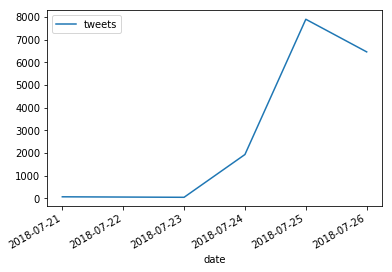

In [13]:
datestrings = daily_tweets['_id'].apply(dictionary_to_datestring)
daily_tweets['date'] = pd.to_datetime(datestrings)

daily_tweets.drop('_id', axis=1, inplace=True)
daily_tweets.sort_values('date', inplace=True)
daily_tweets.set_index('date', inplace=True)
daily_tweets.plot()

## Tweet Locations

In [16]:
not_null = { '$ne' : None }
nonnull_geo = {'geo' : not_null }
keep_geo = { 'geo' : 1 }

cursor = collection_reference.find(nonnull_geo, keep_geo)
collection_reference.count_documents(nonnull_geo)

1963

In [17]:
geo_tweets = pd.DataFrame(list(cursor))

In [18]:
list(geo_tweets.head(5)['geo'].values)

[{'type': 'Point', 'coordinates': [38.85, -119.94]},
 {'type': 'Point', 'coordinates': [38.93, -120.05]},
 {'type': 'Point', 'coordinates': [38.72, -119.89]},
 {'type': 'Point', 'coordinates': [38.31, -119.6]},
 {'type': 'Point', 'coordinates': [38.4, -119.54]}]

In [19]:
def parse_geo_from_tweets(tweets):
    geo = pd.DataFrame(list(tweets['geo'].values))
    return geo

In [20]:
geo = parse_geo_from_tweets(geo_tweets)
geo.sample(5)

,coordinates,type
567,"[34.0729547, -118.3892059]",Point
1362,"[33.45632843, -117.10661144]",Point
1686,"[34.0522, -118.243]",Point
615,"[34.09931, -118.34478]",Point
1847,"[34.09858, -118.32303]",Point


In [21]:
import folium
starting_loc = [34.0689, -118.4452]
la_map = folium.Map(location=starting_loc, zoom_start=13)

In [22]:
for loc in geo.coordinates:
    folium.Marker(loc).add_to(la_map)

In [23]:
la_map